In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 100)

## Selection

In [3]:
financial_ratios_table = pd.read_csv('../../DATA/MODEL/transformed_set.csv')

C:\Users\matus.rohal\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3433: DtypeWarning: Columns (110) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
# def sal_class_function(x):
#     if x is None or x != x or x < 50000: return "<50,000"
#     if x < 100000: return "00,050,000 - 100,000"
#     if x < 500000: return "00,100,000 - 500,000"
#     if x < 1000000: return '00,500,000 - 1,000,000'
#     if x < 3000000: return '01,000,000 - 3,000,000'
#     if x < 15000000: return '03,000,000 - 15,000,000'
#     if x < 30000000: return '15,000,000 - 30,000,000'
#     if x < 150000000: return '30,000,000 - 150,000,000'
#     return '>150,000,000'

def sal_class_function(x):
    if x is None or x != x or x <= 50000: return "0. <50,000"
    if x <= 2000000: return "1. Mikro"
    if x <= 10000000: return "2. Malý"
    if x <= 50000000: return "3. Stredný"
    return "4. Veľký"
    
financial_ratios_table['sal_class'] = financial_ratios_table['REV'].apply(sal_class_function)

In [5]:
financial_ratios_table['sknace_division'] = financial_ratios_table['sknace_division'].fillna('-')

## Outliers

In [6]:
financial_ratios_table.query('CA >= 0 and CASH >= 0 and CL >= 0 and NCL >= 0 and TA >= 0 and TL >= 0 and CC >= 0 and INV >= 0 and REV >= 0 and SAL >= 0 and COST >= 0 and costs_of_merchandise_sold >= 0', inplace=True)

In [7]:

FINANCIAL_RATIOS = ['L1',
       'L2', 'L3', 'NCL_CF', 'CASH_TA', 'INV_COGS', 'CC_SAL', 'TL_COST',
       'CL_COST', 'SAL_TA', 'EQ_TA', 'EQ_TL', 'CL_CC', 'LTC_NCA', 'TZ',
       'CF_TL', 'CL_TA', 'NCL_TA', 'EBT_REV', 'ROS', 'EAT_REV', 'ROA', 'ROE',
       'CF_TA', 'CF_SAL', 'LABOR_EAT', 'LABOR_REV']

PRIMARY_METRICS = [
    'CA', 'CASH',
       'CL', 'EQ', 'NCL', 'TA', 'TL', 'CC', 'INV', 'CF_NETTO', 'CF_SELFFIN',
       'REV', 'VA', 'OE', 'EAT', 'EBIT', 'SAL', 'COST', 'INT'
]

SKNACE_DIVISIONS =  sorted(list(financial_ratios_table['sknace_division'].unique()))
YEARS = sorted(list(financial_ratios_table['year'].unique()))
SAL_CLASSES =  sorted(list(financial_ratios_table['sal_class'].unique()))
TEMPLATES = list(financial_ratios_table['financial_report_template_id'].unique())

In [8]:
financial_ratios_table['establishment_year'] = pd.to_datetime(financial_ratios_table['establishment_date'], errors='coerce').dt.year

In [9]:
financial_ratios_table['establishment_year']

financial_ratios_table['years_since_est'] = financial_ratios_table['year'] - financial_ratios_table['establishment_year']
financial_ratios_table.query('years_since_est > 1', inplace=True)
financial_ratios_table.drop(columns=['years_since_est'], inplace=True)

In [10]:

financial_ratios_table.query('ownership_category_code in [2, 7, 8] and establishment_date <= "2013-01-01"', inplace=True)
# financial_ratios_table.query('ownership_category_code in [2, 7, 8] and sknace_division in ["G","M","C","F","N","L","J","H","Q","I","A"] and establishment_date <= "2013-01-01"', inplace=True)

In [11]:
financial_ratios_table.query('sal_class in ["2. Malý", "3. Stredný"] and period_length == 12 and financial_report_template_id == 699')['sknace_division'].value_counts()

G    19088
C    12875
F     4717
H     4202
M     3910
N     2775
L     2219
J     2124
A     1887
Q      822
I      787
D      680
E      521
K      484
R      423
B      194
S      136
P      119
O       27
Name: sknace_division, dtype: int64

In [12]:
# def sknace_grouping(x):
#     if x not in ["G","M","C","F","N","L","J","H","Q","I","A"]:
#         return 'other'
#     return x

# financial_ratios_table['sknace_division'] = financial_ratios_table['sknace_division'].apply(sknace_grouping)

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import yeojohnson

def plot_histograms(df, columns, apply_yeojohnson_transform=False):
    # Plotting the histograms
    fig, axes = plt.subplots(nrows=int(len(columns) / 3) + 1, ncols=3, figsize=(20, 30))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        ax = axes[i]

        data = df.query(f'{column} == {column} and {column} != 0')[column]

        # Calculate initial skewness
        data_skewness = round(data.skew(), 1)

        # Apply Yeo-Johnson transformation if requested
        if apply_yeojohnson_transform:
            data, _ = yeojohnson(data)  # The function returns a tuple of transformed data and lambda
            transformation = 'Yeo-Johnson Transformed'
        else:
            transformation = 'Original'

        # Calculate skewness after transformation
        data_skewness_new = round(pd.Series(data).skew(), 1)  # Ensure data is a Series for skew method
        
        Q1 = np.quantile(data, 0.25)
        Q2 = np.quantile(data, 0.5)
        Q3 = np.quantile(data, 0.75)
        
        IQR = Q3 - Q1

        bin_width = 2 * IQR / (len(data) ** (1/3))
        num_bins = min(100, int(np.ceil((np.max(data) - np.min(data)) / bin_width)))

        sns.histplot(data, bins=num_bins, kde=True, color='skyblue', edgecolor='black', ax=ax)
        ax.set_title(f'{column}, {transformation}, original skewness: {data_skewness}, transformed skewness: {data_skewness_new}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')

        # Calculate bounds for displaying z-score thresholds
        mean = np.mean(data)
        std = np.std(data)
        for color, z_score_threshold in [('red', 3), ('blue', 2)]:
            lower_bound = mean - z_score_threshold * std
            upper_bound = mean + z_score_threshold * std
            ax.axvline(lower_bound, color=color, linewidth=1, label=f'Lower Bound, Threshold {z_score_threshold}')
            ax.axvline(upper_bound, color=color, linestyle='--', linewidth=1, label=f'Upper Bound, Threshold {z_score_threshold}')

        # Add vertical line for median
        ax.axvline(Q2, color='green', linestyle='-', linewidth=2, label='Median')

        # Only add legend to the first plot for clarity
        if i == 0:
            ax.legend()

    # Hide empty subplots
    for j in range(len(columns), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Example usage with a DataFrame 'df' and some financial ratio columns
# df = pd.read_csv('path_to_your_data.csv')
# plot_histograms(df, ['CurrentRatio', 'QuickRatio', 'DebtEquityRatio', 'GrossMargin', 'NetProfitMargin'], apply_yeojohnson_transform=True)



C:\Users\matus.rohal\AppData\Local\Temp\ipykernel_15644\467162688.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset[col] = subset[col].apply(lambda x: winsorize(x, threshold_min, threshold_max))


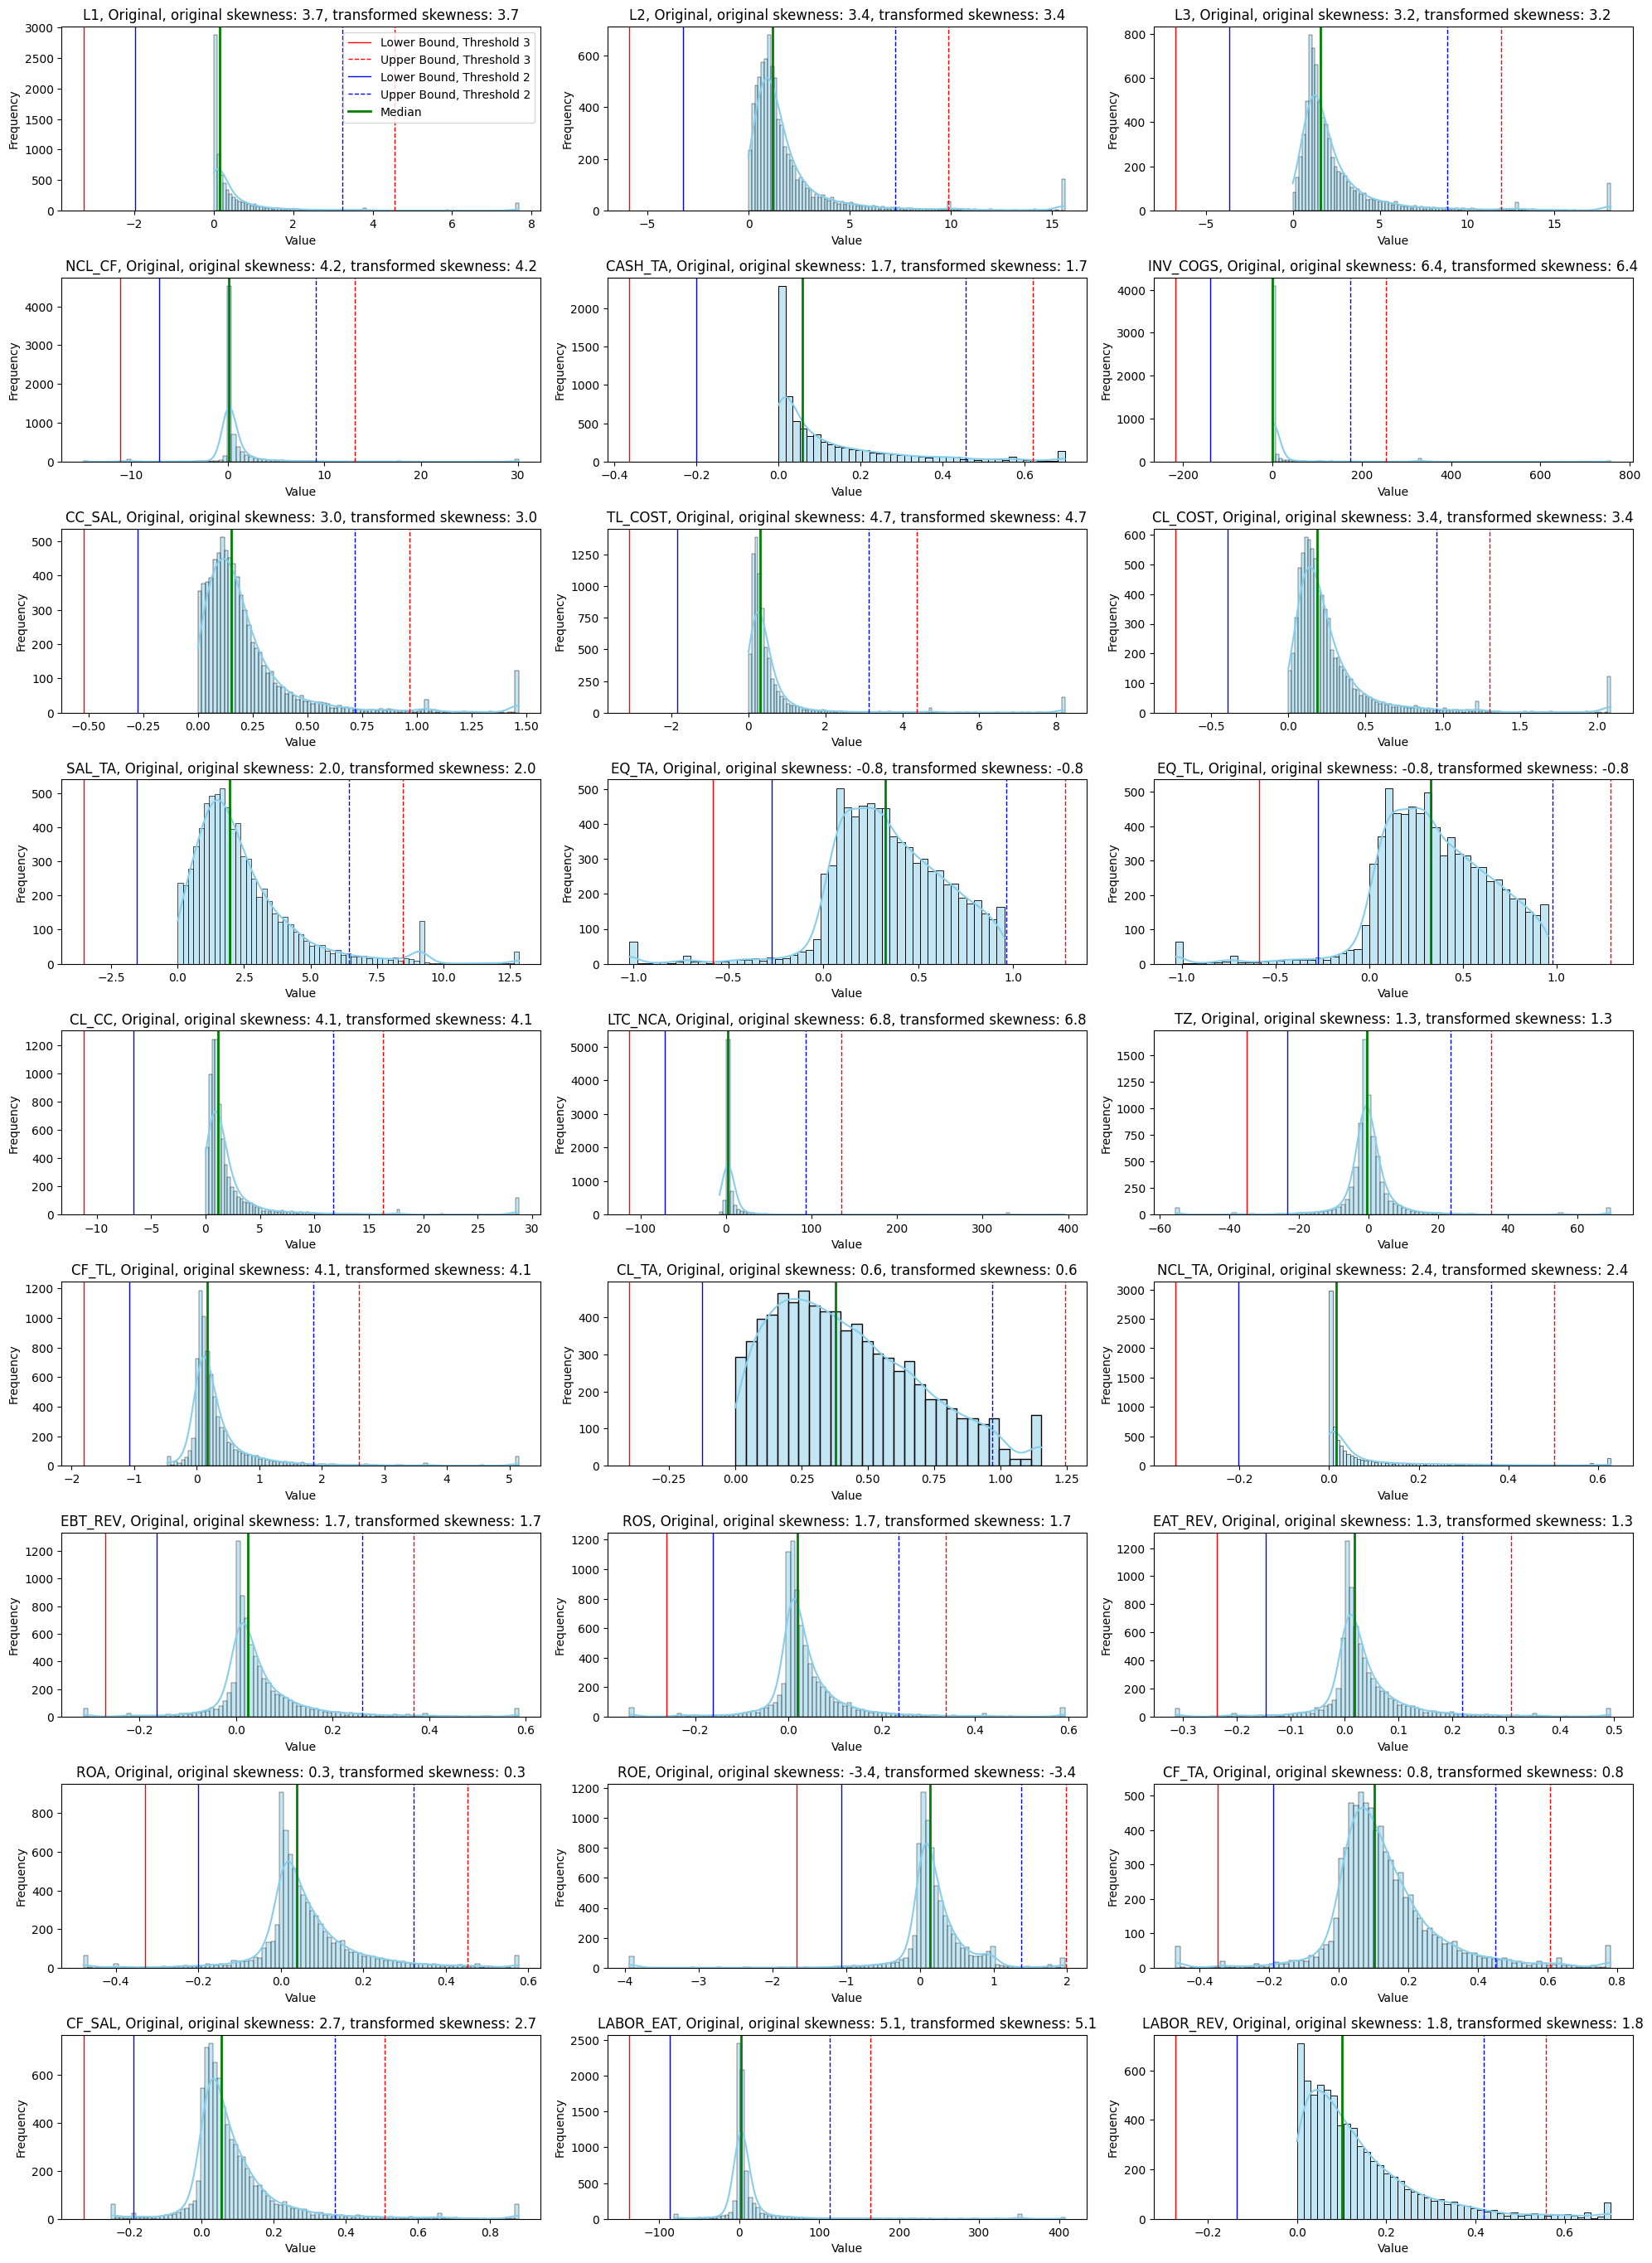

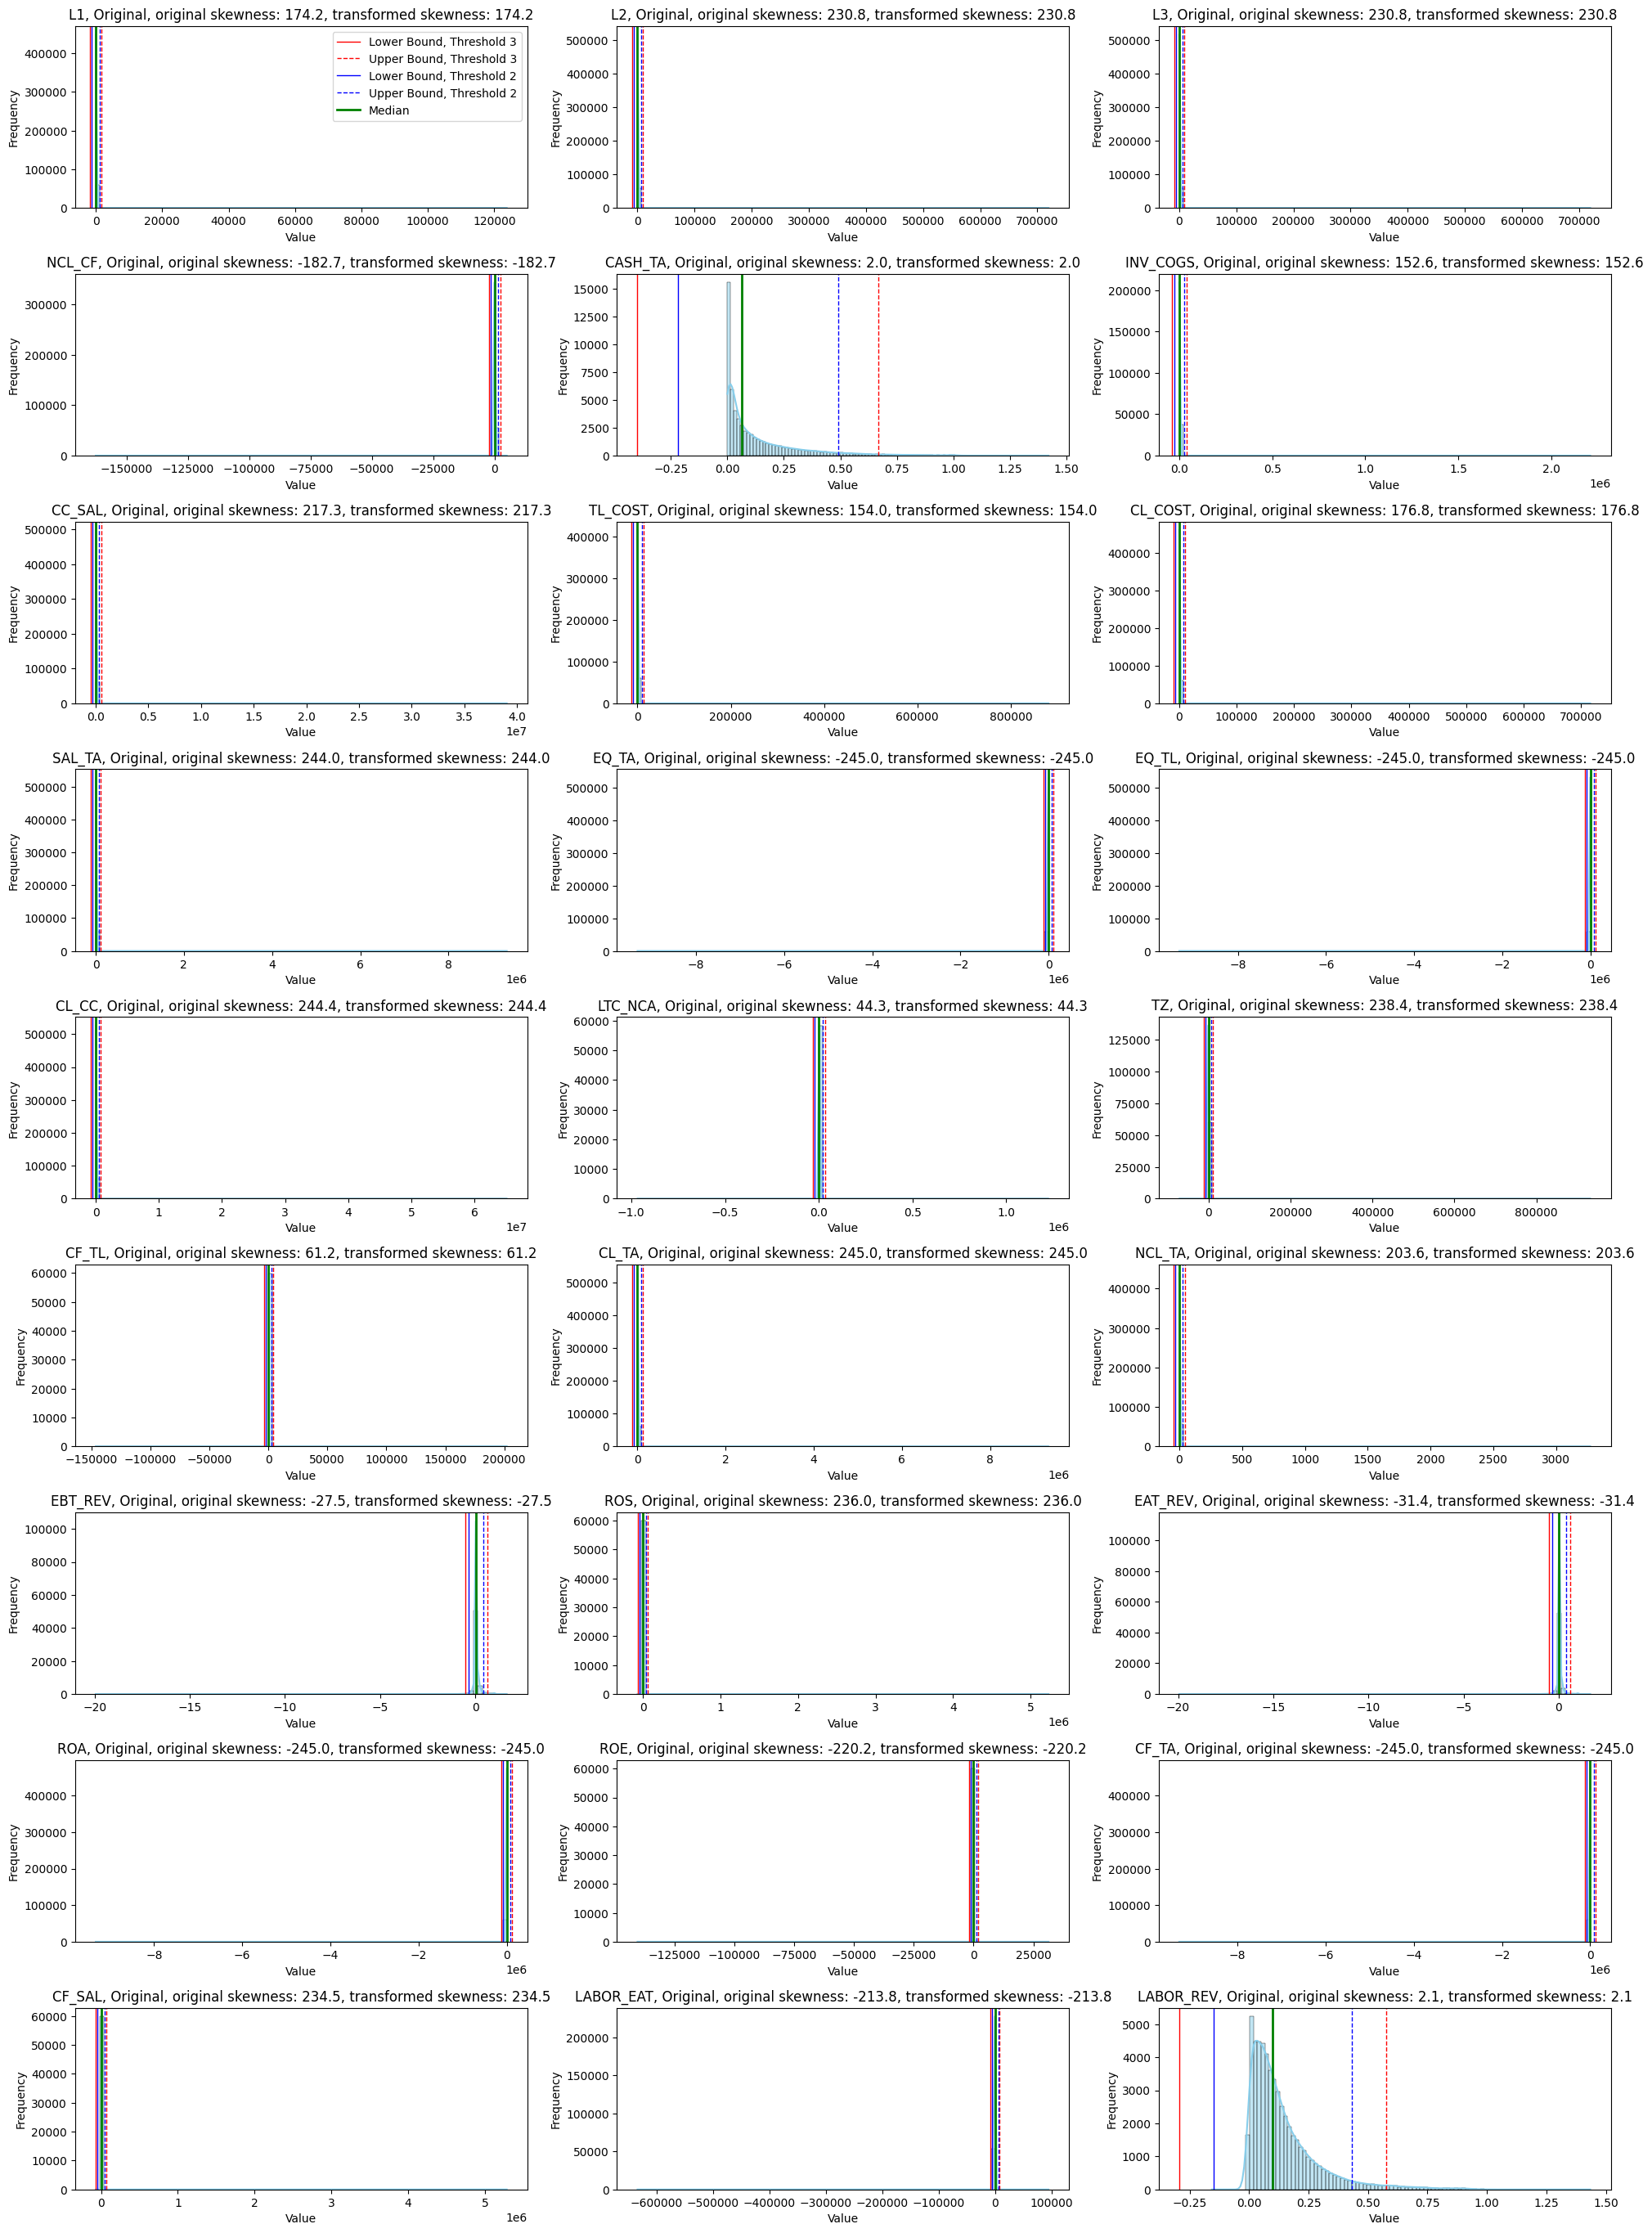

In [15]:



plot_histograms(financial_ratios_table.query('sal_class in ["2. Malý", "3. Stredný"]'), FINANCIAL_RATIOS, False)


In [16]:

def fill_missing_values_mean(data):
    data_filled = data.fillna(data.mean())
    data_filled_fallback = data_filled.fillna(0)
    return data_filled_fallback


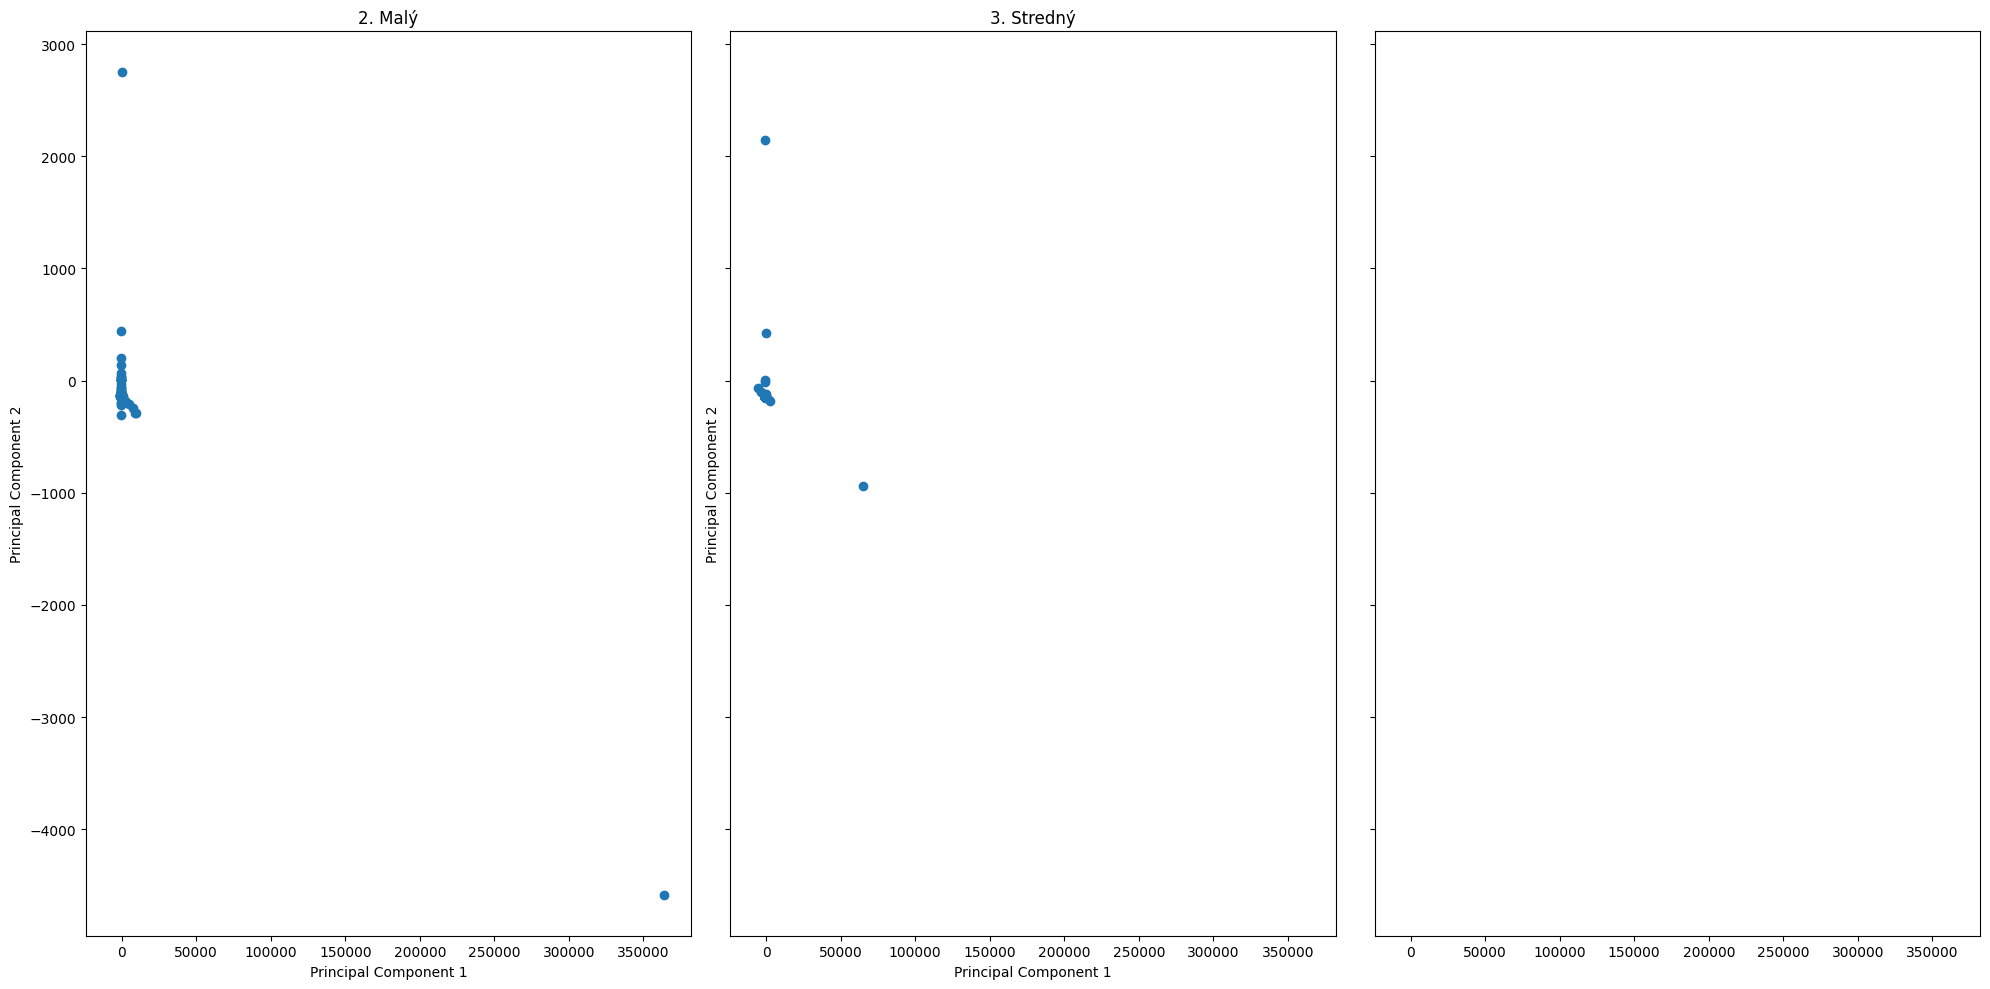

In [17]:
from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib import pyplot as plt


SAL_CLASSES2 = ["2. Malý", "3. Stredný"]

fig, axes = plt.subplots(ncols=3, nrows=len(SAL_CLASSES2) // 3 + 1, sharex=True, sharey=True, figsize=(20, 10))
axes = axes.flatten()

data_group = financial_ratios_table.query('year == 2018')

data = fill_missing_values_mean(data_group[FINANCIAL_RATIOS]).values
            
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data)


for i, sknace in enumerate(SAL_CLASSES2):
    ax = axes[i]
    class_indices = data_group['sal_class'] == sknace
    
    ax.scatter(pca_data[class_indices, 0], pca_data[class_indices, 1], label=sknace)

    ax.set_title(f'{sknace}')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

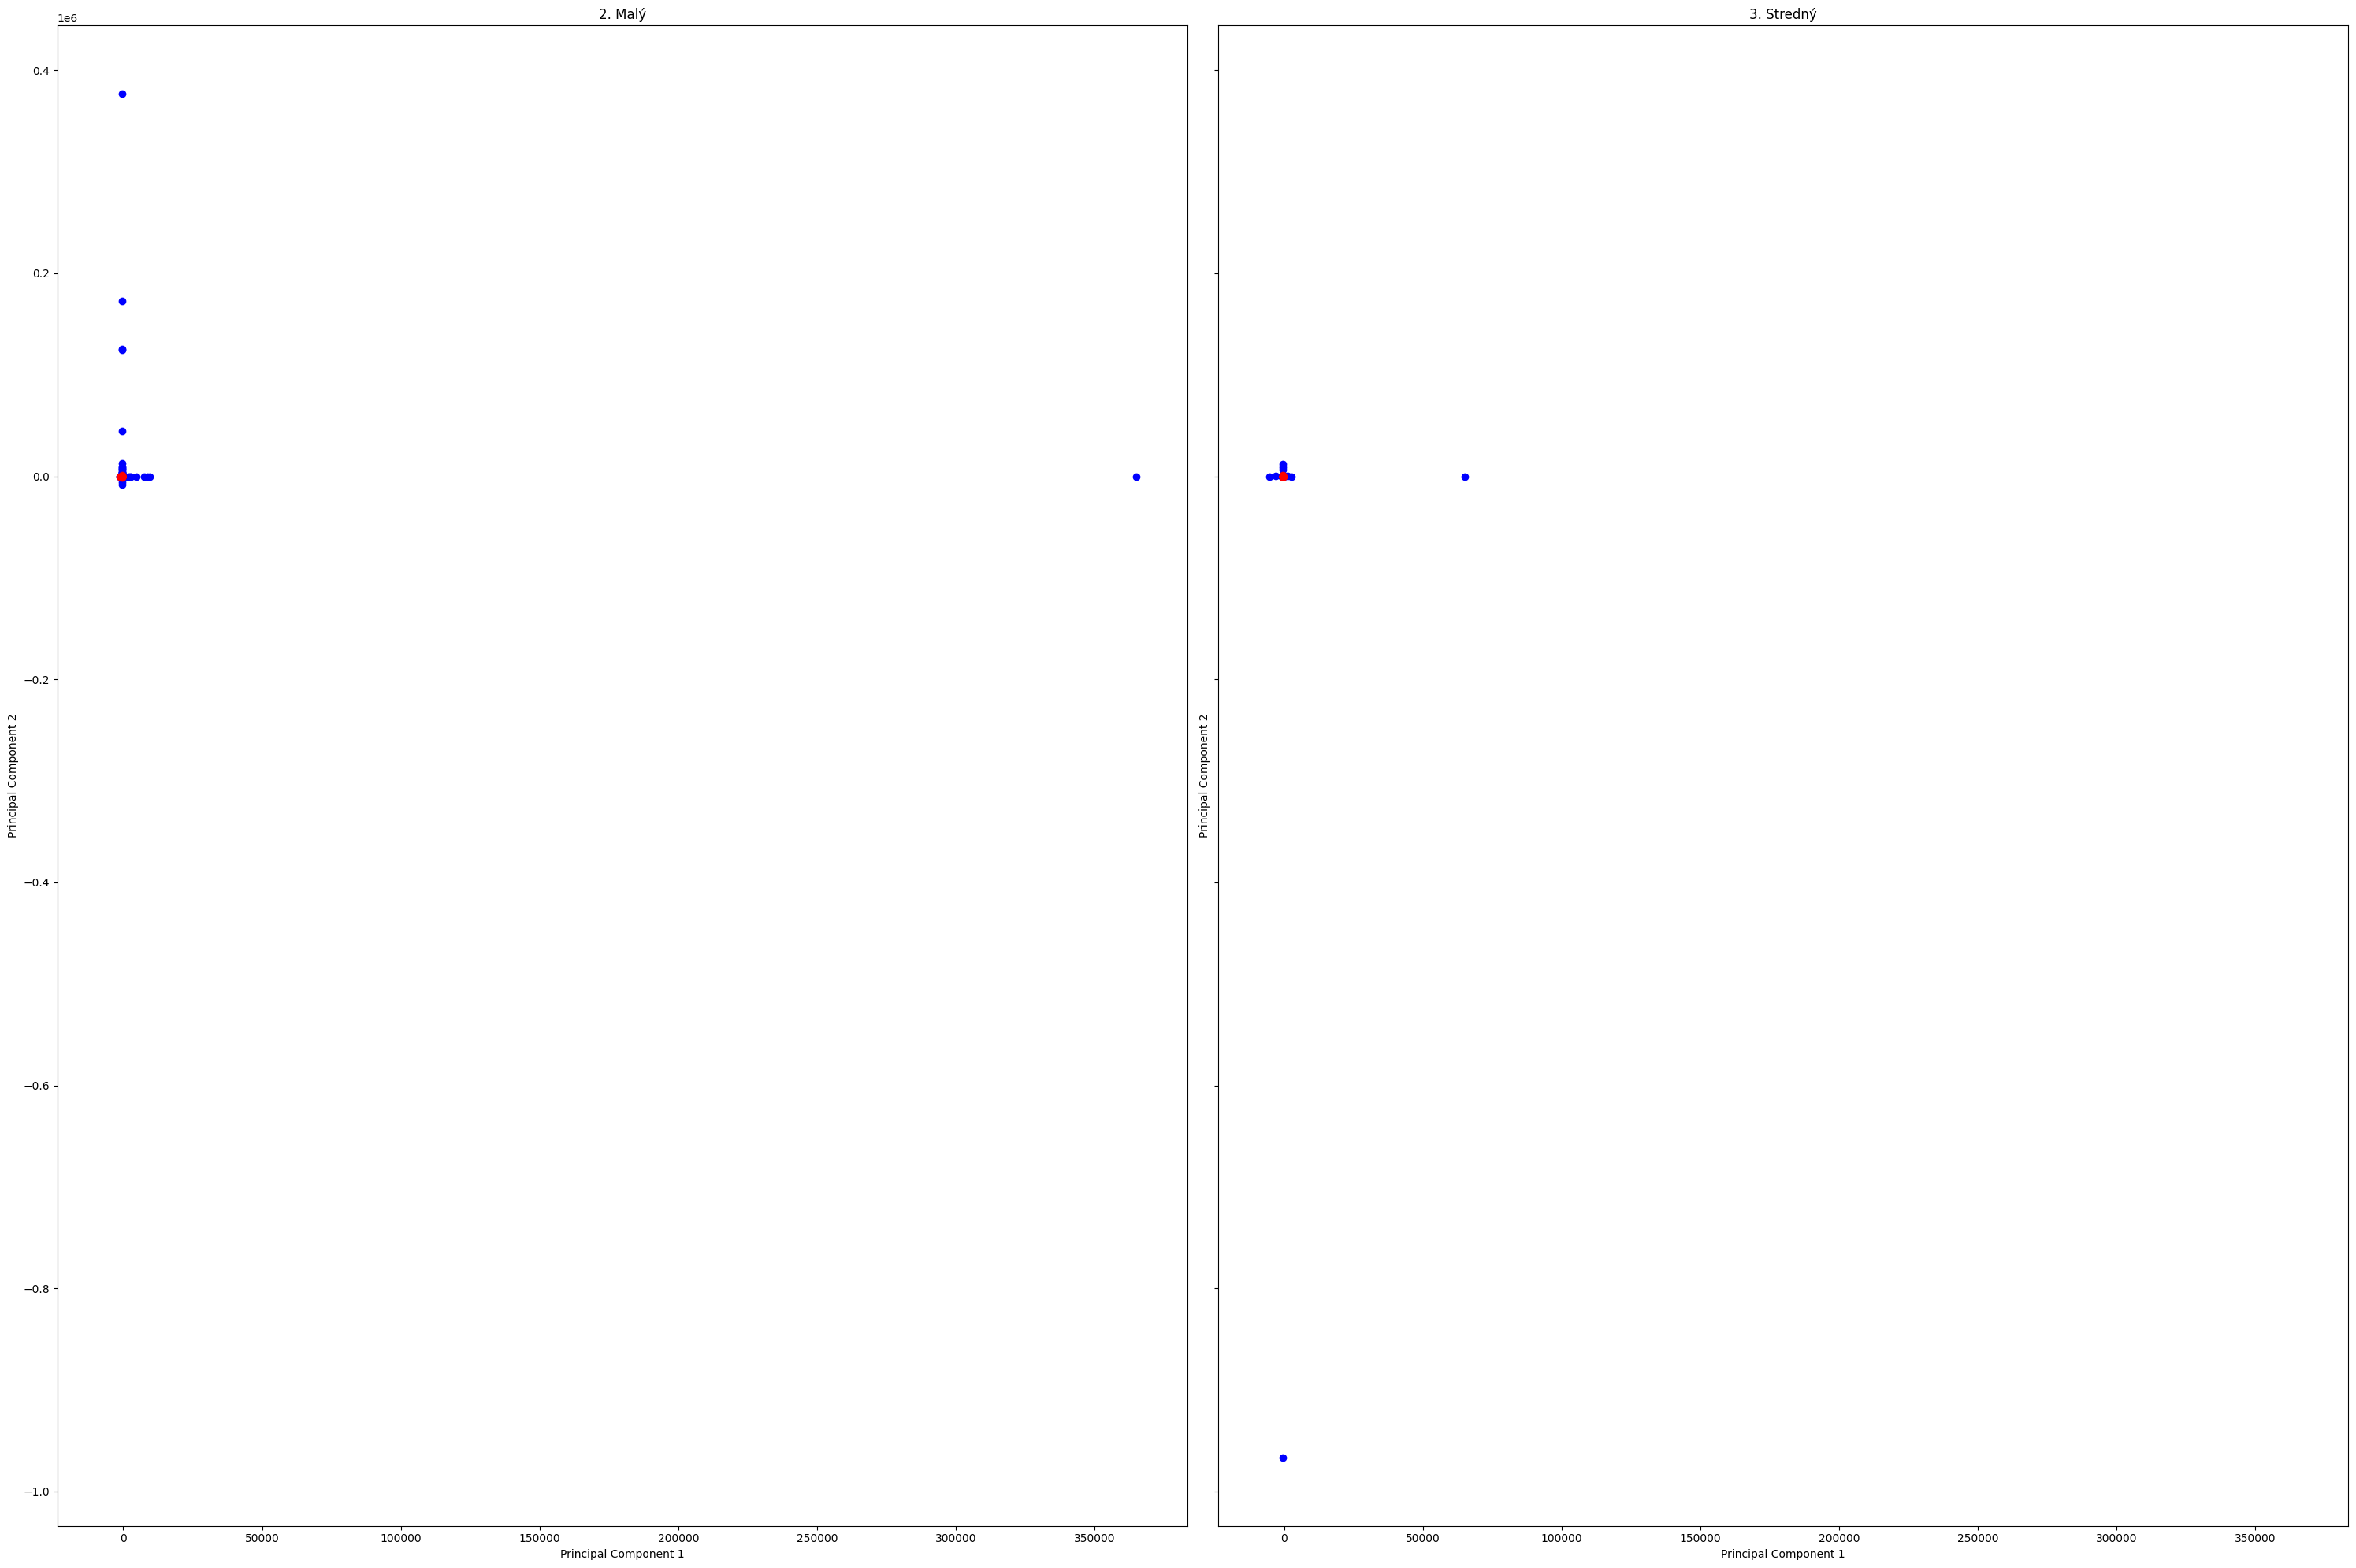

In [18]:
DISTRESS_CRITERIA =  ['DPHZ_vat_registration_cancelled',
 'DPHZ_vat_registration_cancelled_1y_off',
 'DPHZ_vat_registration_cancelled_2y_off',
 'DPHZ_vat_registration_cancelled_3y_off',
 'RU_event',
 'RU_event_1y_off',
 'RU_event_2y_off',
 'RU_event_3y_off',
 'RUZ_cancelled',
 'RUZ_cancelled_1y_off',
 'RUZ_cancelled_2y_off',
 'RUZ_cancelled_3y_off']

DISTRESS_CRITERION = 'RUZ_cancelled_3y_off'

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(30, 20), sharex=True, sharey=True)
axes = axes.flatten()

data_group = financial_ratios_table.query('year == 2018 and period_length == 12').sort_values(DISTRESS_CRITERION, ascending=True)

data_group[FINANCIAL_RATIOS] = fill_missing_values_mean(data_group[FINANCIAL_RATIOS])

            
pca = PCA(n_components=2)


pca_data = pca.fit_transform(data_group[FINANCIAL_RATIOS])


colors = ['blue', 'red']  # Define colors for RUZ_cancelled categories

for i, sal_class in enumerate(SAL_CLASSES2):
    ax = axes[i]
    for j, ruz_cancelled in enumerate([False, True]):
        class_indices = (data_group['sal_class'] == sal_class) & (data_group[DISTRESS_CRITERION] == ruz_cancelled)
        ax.scatter(pca_data[class_indices, 0], pca_data[class_indices, 1], label=f'{DISTRESS_CRITERION}={ruz_cancelled}', color=colors[j])


    ax.set_title(f'{sal_class}')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

c:\Users\matus.rohal\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
c:\Users\matus.rohal\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


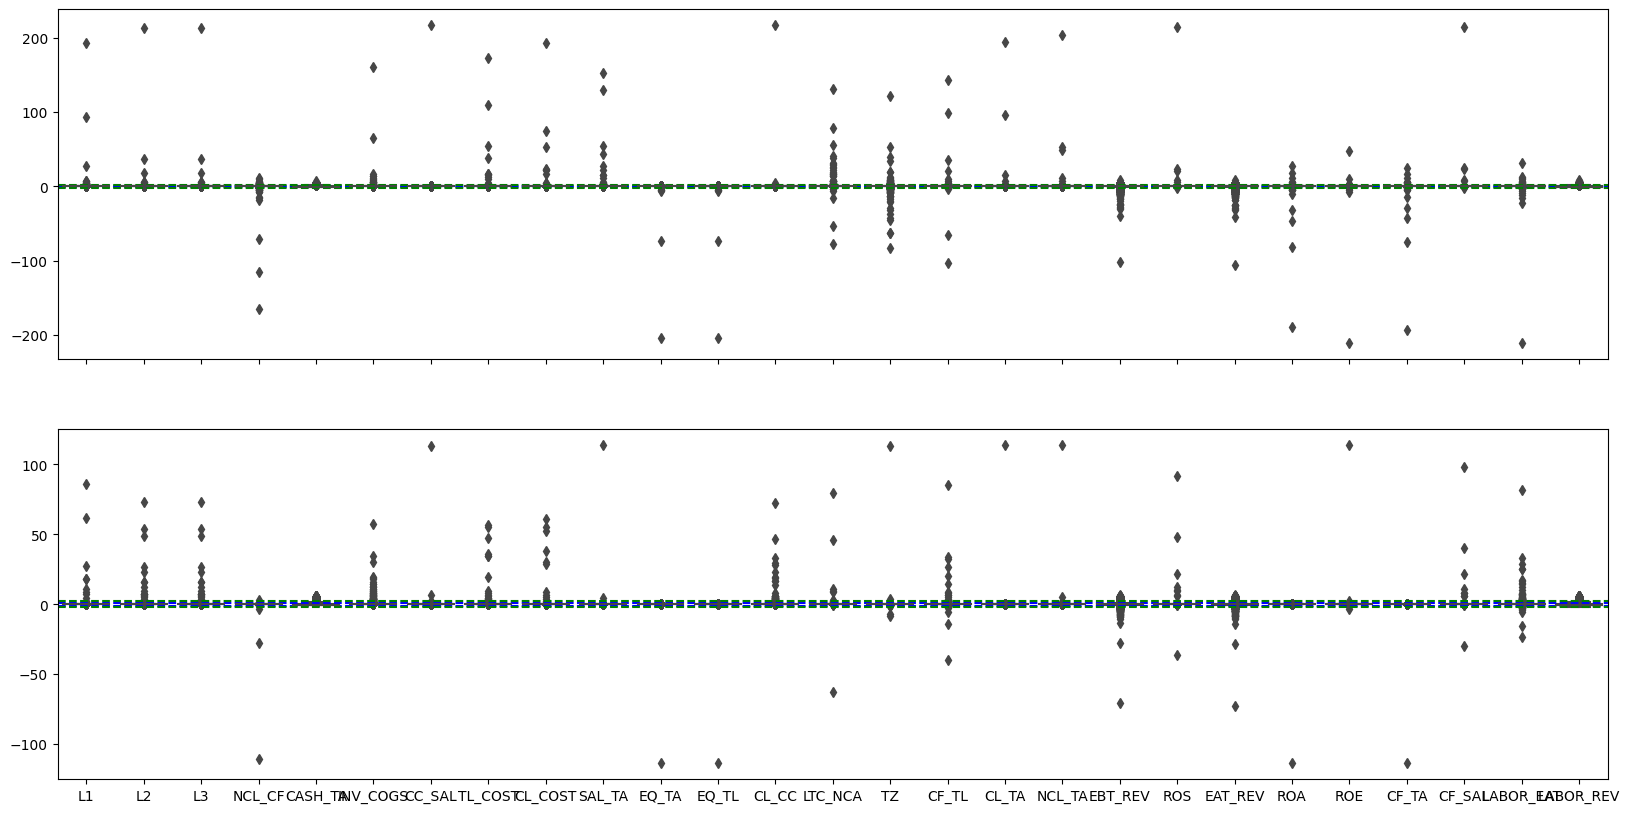

In [19]:
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler


SAL_CLASSES2 = ["2. Malý", "3. Stredný"]


fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True, sharey=False, figsize=(20, 10))
axes = axes.flatten()

for i, sal_class in enumerate(SAL_CLASSES2):
    scaler = StandardScaler()
    df_normalized = financial_ratios_table.query('sal_class == @sal_class')  # Create a copy to avoid changing the original DataFrame
    df_normalized[FINANCIAL_RATIOS] = scaler.fit_transform(df_normalized[FINANCIAL_RATIOS])


    sns.boxplot(data=df_normalized[FINANCIAL_RATIOS], ax=axes[i])

    axes[i].axhline(1, color='blue', linestyle='--', linewidth=1.5, label='+1 SD')
    axes[i].axhline(-1, color='blue', linestyle='--', linewidth=1.5, label='-1 SD')
    axes[i].axhline(2, color='green', linestyle='--', linewidth=1.5, label='+2 SD')
    axes[i].axhline(-2, color='green', linestyle='--', linewidth=1.5, label='-2 SD')


In [20]:
financial_ratios_table.to_csv('../../DATA/FINAL/transformed_set_enriched.csv', index = False)